In [21]:
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import Dataset, DataLoader
from typing import Tuple, List
from joblib import load
from tqdm import tqdm


# 필요한 다른 라이브러리들을 여기에 import


def load_data(file_path):
    """
    데이터를 로드
    필요한 경우 이 함수를 수정
    """
    return pd.read_csv(file_path)

def preprocess_data(data, param):
    """
    데이터 전처리
    필요한 전처리 과정을 이 함수에 구현
    """
    # 전처리 코드
    cat_features, num_features, discard = SelectFeature()
    return preprocess_test(data, cat_features, num_features, discard, param["scaler"], param["le"])

def train_model(data):
    """
    모델 학습
    학습이 필요한 경우 이 함수에 구현
    """
    # 최종 모델 학습 코드는 여기에 작성
    model = None  # 예시
    return model


def save_model(model, path):
    """
    모델 저장
    학습된 모델의 파라미터 또는 모델을 저장
    """
    # 모델 저장 코드는 여기에 작성


def load_model(aepth, dagmmpth, dtpth): # 또는 load_model(model, path)
    """
    모델 로드
    제출한 학습된 모델의 파라미터를 모델에 로드
    """
    # 모델 로드 코드는 여기에 작성
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    cat_features, num_features, discard = SelectFeature()
    ae = AutoEncoder(encoding_dim=31, cat_features=cat_features, num_features=num_features, num_classes=1)
    ae.load_state_dict(torch.load(aepth))
    ae.to(device)
    dagmm = DAGMM(
        encoding_dim=28,
        n_gmm=8,
        cat_features=cat_features,
        num_features=num_features,
    )
    dagmm.load_state_dict(torch.load(dagmmpth))
    dagmm.to(device)
    param = load(dtpth)
    dt = param["model"]
    return ae, dagmm, dt, param


def predict(ae, dagmm, tree, cat_x, num_x, y):
    """
    test_submission.csv 데이터에 대해 예측
    이 함수에 실제 예측 방식을 구현
    """
    # 예측 코드는 여기에 작성
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    dataset = TEST_DATASET(cat_x, num_x, y, device)
    data_loader = DataLoader(dataset, batch_size=1024, shuffle=False)

    ae_errors = []
    dagmm_energy = []
    tree_embeddings = []
    all_labels = []

    # AE 및 DAGMM 처리
    ae.eval()
    dagmm.eval()

    with torch.no_grad():
        for cat_fe, num_fe, labels in tqdm(data_loader):
            #AE
            decoded, x = ae(cat_fe, num_fe)
            batch_aerror = torch.mean((decoded - x) ** 2, dim=1).cpu().numpy()
            ae_errors.extend(batch_aerror)

            #DAGMM
            x, enc, dec, z, gamma = dagmm(cat_fe, num_fe)
            phi, mu, cov = dagmm.compute_gmm_params(z, gamma)
            batch_dagmm_energy = dagmm.compute_energy(z, phi, mu, cov).cpu().numpy()
            dagmm_energy.extend(batch_dagmm_energy)

            # Tree Embeddings
            batch_tree_emb = ae.get_embedding(cat_fe, num_fe).cpu().numpy()
            tree_embeddings.extend(batch_tree_emb)

            all_labels.extend(labels.cpu().numpy())

    tree_embeddings = np.array(tree_embeddings)
    tree_predictions = tree.predict(tree_embeddings)
    all_labels = np.array(all_labels)

    ae_threshold = np.percentile(ae_errors, 90)
    dagmm_threshold = np.percentile(dagmm_energy, 90)

    ae_predictions = (np.array(ae_errors) > ae_threshold).astype(int)
    dagmm_predictions = (np.array(dagmm_energy) > dagmm_threshold).astype(int)

    # 최종 예측: 3개 중 2개 이상 positive일 경우 1, 아니면 0
    final_predictions = (ae_predictions + dagmm_predictions + tree_predictions >= 2).astype(int)
    df = pd.DataFrame(final_predictions, columns=["prediction"])
    #predictions = df["prediction"].map({0: 'No', 1: 'Yes'})
    predictions = df["prediction"]

    return predictions, all_labels


def save_predictions(data, predictions, output_file):
    """
    예측 결과 저장
    """
    data['Is Fraud?'] = predictions
    data.to_csv(output_file, index=False)


# 필요한 다른 함수들은 여기에 정의
## ----------------------------------PREPROCESS
# Constant Definition
TRAIN_MONTH_START = 1
TRAIN_MONTH_END = 9
IQR_MULTIPLIER = 1.5
NONE_LABEL = 'None'

def SelectFeature():

    cat_features = [
        'Gender',
        'Zipcode',
        'Day',
        'Card Brand',
        'Card Type',
        'Has Chip',
        'Whether Security Chip is Used',
        'Error Message',
        'WeekDay',
        'Credit Signal',
        'PIN Change',
        'Security Level'
    ]
    num_features = [
        'Current Age',
        'Retirement Age',
        'Per Capita Income - Zipcode',
        'Yearly Income',
        'Total Debt',
        'Credit Score',
        'Valid Month',
        'Credit Limit',
        'Since Open Month',
        'Year PIN last Changed',
        'Amount',
        'Credit Util',
        'Years Changed PIN',
        'Security Score'
    ]
    discarded = [
        'User',
        'Birth Year',
        'Birth Month',
        'Year',
        'Month',
        'Merchandise Code',
        'Card',
        'Card Number',
        'Expires',
        'Acct Open Date',
    ]
    return cat_features, num_features, discarded
# need to separate by models
def evaluate_validation(model, data):
    model.eval()
    with torch.no_grad():
        y_pred = model(data)
        return y_pred

def evaluate_test(model, data):
    model.eval()
    with torch.no_grad():
        y_pred = model(data)
        return y_pred


# Data Preprocess
def zipcode(df) :
    trans = df.copy()
    trans['Zipcode'] = (trans['Zipcode'] // 10000).astype(str)
    return trans

def convert_date_to_weekday(df, col_Year, col_Month, col_Day):

    # 날짜 컬럼 생성
    df['WeekDay'] = pd.to_datetime(
        df[col_Year].astype(str) + '-' +
        df[col_Month].astype(str).str.zfill(2) + '-' +
        df[col_Day].astype(str).str.zfill(2)
    )

    # 요일 추출 (0=월요일, 6=일요일)
    df['WeekDay'] = df['WeekDay'].dt.dayofweek

    # 요일 이름으로 변환
    weekday_map = {
        0: 'MON',
        1: 'TUE',
        2: 'WED',
        3: 'THU',
        4: 'FRI',
        5: 'SAT',
        6: 'SUN'
    }

    df['WeekDay'] = df['WeekDay'].map(weekday_map)

    return df

def security_level(df: pd.DataFrame) -> pd.DataFrame:
    df['Years Changed PIN'] = df['Year'] - df['Year PIN last Changed']

    # PIN 변경 기간에 따른 점수 조건
    conditions = [
        (df['Years Changed PIN'] >= 5),
        (df['Years Changed PIN'] < 5),
        (df['Years Changed PIN'] < 3),
        (df['Years Changed PIN'] < 1),
        (df['Years Changed PIN'] < 0)
    ]

    choices = [0, 0.25, 0.5, 0.75, 1]

    level = ['BAD', "LOW", "NORMAL", "HIGH", "SECURE"]

    # PIN 점수 계산
    df['PIN Change'] = np.select(conditions, choices, default=0)

    # 최종 보안 레벨 계산
    df['Security Score'] = (df['Has Chip'].astype(int) * 0.3 + df['PIN Change'] * 0.7)

    # 조건을 내림차순으로 변경
    levels = [
        (df['Security Score'] >= 0.8),
        (df['Security Score'] >= 0.6),
        (df['Security Score'] >= 0.4),
        (df['Security Score'] >= 0.2),
        (df['Security Score'] >= 0)
    ]

    df['Security Level'] = np.select(levels, level[::-1], default="BAD")  # level 리스트도 역순으로 적용

    return df

def credit_util(df: pd.DataFrame) -> pd.DataFrame:
    df['Credit Util'] = df['Amount'] / df['Credit Limit']
    df['Credit Util'] = np.where(np.isinf(df['Credit Util']), 1, df['Credit Util'])
    df['Credit Util'] = np.where(df['Credit Limit'] == 0, 1, df['Credit Util'])
    df['Credit Util'] = np.where(df['Amount'] == 0, 1, df['Credit Util'])
    conditions = [
        (df['Credit Util'] <= 0.2),
        (df['Credit Util'] <= 0.5),
        (df['Credit Util'] <= 0.8),
        (df['Credit Util'] > 0.8)
    ]

    choices = ['NORMAL', 'CAUTION', 'WARNING', 'DANGER']

    df['Credit Signal'] = np.select(conditions, choices, default='DANGER')

    return df

## feature modify
def translation(df: pd.DataFrame) -> pd.DataFrame :
    if 'Acct Open Date' not in df.columns :
        raise ValueError("TRANSITION ValueError : 'Acct Open Date' COLUMN DOES NOT EXIST")

    if 'Error Message' not in df.columns :
        raise ValueError("TRANSITION ValueError : 'Error Message' COLUMN DOES NOT EXIST")

    if 'Year' not in df.columns :
        raise ValueError("Year ValueError : 'Year' COLUMN DOES NOT EXIST")

    if 'Month' not in df.columns :
        raise ValueError("Month ValueError : 'Month' COLUMN DOES NOT EXIST")

    if 'Day' not in df.columns :
        raise ValueError("Day ValueError : 'Day' COLUMN DOES NOT EXIST")

    trans = df.copy()

    # Error Message -> bool
    trans['Error Message'] = trans['Error Message'].astype(bool)
    # zipcode mapping by Administrative district
    trans = zipcode(trans)
    # Add Transaction Week
    trans = convert_date_to_weekday(trans, 'Year', 'Month', 'Day')
    # Add Months from Account Open Date
    trans['Since Open Month'] = (trans['Year'] - trans['Acct Open Date'].str[-4:].astype(int)) * 12 + (trans['Month'] - trans['Acct Open Date'].str[:2].astype(int)).astype(int)
    # Add Valid Months
    trans['Valid Month'] = (trans['Expires'].str[-4:].astype(int) - trans['Year']) * 12 + (trans['Expires'].str[:2].astype(int)- trans['Month'].astype(int))
    # Add Credit Utilization
    trans = credit_util(trans)
    # Add Security Level
    trans = security_level(trans)

    # whole dataset
    return trans

# MUST BE EXECUTED AFTER TRANSITION
def discard(df: pd.DataFrame, discarded : List[str]) -> pd.DataFrame :
    if not all(feature in df.columns for feature in discarded) :
        raise ValueError("DISCARD ValueError : NO COLUMN IN GIVEN DATASET")

    # whole dataset
    return df.drop(columns=discarded)

## Train-Valid Set split
def split_by_date(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame] :
    # Value Error : There is no any Month in given DATASET
    if 'Month' not in df.columns :
        raise ValueError("SPLIT ValueError : 'Month' COLUMN DOES NOT EXIST.")

    mask = df['Month'].between(TRAIN_MONTH_START, TRAIN_MONTH_END)
    train_df = df[mask]
    val_df = df[~mask]


    return train_df, val_df

## num_features
def iqr(df: pd.DataFrame, num_features: List[str]) -> pd.DataFrame :
    # ValueError - NO COLUMN
    if not all(feature in df.columns for feature in num_features) :
        raise ValueError("IQR ValueError : NO COLUMN IN GIVEN DATASET")

    num_df = df.copy()
    mask = pd.Series(True, index=df.index)

    for col in num_features :
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        l_bound = Q1 - IQR_MULTIPLIER * IQR
        u_bound = Q3 + IQR_MULTIPLIER * IQR
        num_df = num_df[(num_df[col] >= l_bound) & (num_df[col] <= u_bound)]

    return num_df

def scale(df: pd.DataFrame, num_features: List[str], scaler: any) -> pd.DataFrame :
    # ValueError - NO COLUMN
    if not all(feature in df.columns for feature in num_features) :
        raise ValueError("SCALE ValueError : NO COLUMN IN GIVEN DATASET")


    df[num_features] = pd.DataFrame(
        scaler.transform(df[num_features]),
        columns = num_features,
        index = df.index,
    )

    return df

## cat_features
def encode(df: pd.DataFrame, cat_features: List[str], label_encoders: any) -> pd.DataFrame :
    # ValueError - NO COLUMN
    if not all(feature in df.columns for feature in cat_features) :
        raise ValueError("ENCODE ValueError : NO COLUMN IN GIVEN DATASET")


    for col in cat_features :
        print(col)
        df[col] = label_encoders[col].transform(df[col].astype(str))

    return df

def get_target(df: pd.DataFrame) -> pd.DataFrame :
    if 'Is Fraud?' not in df.columns:
        raise ValueError("GET_TARGET ValueError : NO TARGET IN GIVEN DATASET")

    target = pd.DataFrame(df['Is Fraud?'] == 'Yes').astype(float)

    return target

def discard_label(df: pd.DataFrame) -> pd.DataFrame :
    if 'Is Fraud?' not in df.columns:
        raise ValueError("DISCARD_TARGET ValueError : NO TARGET IN GIVEN DATASET")

    unlabeled = df[df['Is Fraud?'] == "No"]

    return unlabeled


def preprocess_test(df: pd.DataFrame, cat_features: List[str], num_features: List[str], discarded: List[str], scaler: any, le: any) -> Tuple:

    if df.empty:
        raise ValueError("ValueError : EMPTY DATASET")


    label_encoders = {}

    print("TRANSITION")
    df = translation(df)
    trans = df.copy()

    print("IQR")
    df = iqr(df, num_features)

    print("SPLIT")
    train_df, valid_df = split_by_date(df)

    print("DISCARD")
    #train_df = discard(train_df, discarded)
    valid_df = discard(valid_df, discarded)

    print("SCALE")
    valid_df = scale(valid_df, num_features, scaler)

    print("ENCODE")
    valid_df = encode(valid_df, cat_features, le)

    print("TARGET")
    #train_y = get_target(train_df)
    valid_y = get_target(valid_df)

    print("TRAIN CAT/NUM")
    #train_cat_x = train_df[cat_features]
    #train_num_x = train_df[num_features]

    print("VALID CAT/NUM")
    valid_num_x = valid_df[num_features]
    valid_cat_x = valid_df[cat_features]

    print("RETURN")
    return valid_cat_x, valid_num_x, valid_y

## ----------------------------------MODELS
class BaseModel(nn.Module):
    """
    모델 구조 수정 금지.
    """
    def __init__(self, encoding_dim, cat_features, num_features, num_classes):
        super(BaseModel, self).__init__()
        self.cat_embeddings = nn.ModuleList([nn.Embedding(100, 5) for _ in cat_features])
        self.fc_cat = nn.Linear(len(cat_features) * 5 + len(num_features), 64)
        self.encoder = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
        )
        self.classifier = nn.Sequential(nn.Linear(32, 32),
                                        nn.ReLU(),
                                        nn.Linear(32, 16),
                                        nn.ReLU(),
                                        nn.Linear(16, num_classes))


    def forward(self, x_cat, x_num):
        embeddings = [emb(x_cat[:, i]) for i, emb in enumerate(self.cat_embeddings)]
        x = torch.cat(embeddings + [x_num], dim=1)
        x = self.fc_cat(x)
        encoded = self.encoder(x)
        out = self.classifier(encoded) # 이 레이어의 인풋을 활용할 것.
        return out

class AutoEncoder(BaseModel):
    def __init__(self, encoding_dim, cat_features, num_features, num_classes=1):
        super(AutoEncoder, self).__init__(encoding_dim, cat_features, num_features, num_classes)
        self.input_dim = len(cat_features)*5 + len(num_features)

        # Dropout 추가 및 더 깊은 네트워크 구성
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, self.input_dim)
        )

    def forward(self, x_cat, x_num):
        embeddings = [emb(x_cat[:, i]) for i, emb in enumerate(self.cat_embeddings)]
        x = torch.cat(embeddings + [x_num], dim=1)  # 임베딩된 데이터
        fc_x = self.fc_cat(x)
        encoded = self.encoder(fc_x)
        decoded = self.decoder(encoded)
        return decoded, x  # 임베딩된 데이터와 비교
    # 임베딩 추출, torch.eval() 모드에서 사용
    def get_embedding(self, x_cat, x_num):
        with torch.no_grad():
            embeddings = [emb(x_cat[:, i]) for i, emb in enumerate(self.cat_embeddings)]
            original_x = torch.cat(embeddings + [x_num], dim=1)
            x = self.fc_cat(original_x)
            encoded = self.encoder(x)
        return encoded

class DAGMM(BaseModel):
    def __init__(self, encoding_dim, n_gmm, cat_features, num_features, num_classes=1):
        super(DAGMM, self).__init__(encoding_dim, cat_features, num_features, num_classes)
        self.input_dim = len(cat_features) + len(num_features)
        self.AEDecoder = nn.Sequential(
            nn.Linear(encoding_dim, 48),
            nn.BatchNorm1d(48),
            nn.LeakyReLU(),
            nn.Linear(48, self.input_dim)
        )

        self.estimation = nn.Sequential(
            nn.Linear(encoding_dim + 1, 10),
            nn.LeakyReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(10, n_gmm),
            nn.Softmax(dim=1)
        )

        self.register_buffer("phi", torch.zeros(n_gmm))
        self.register_buffer("mu", torch.zeros(n_gmm, encoding_dim + 1))
        self.register_buffer("cov", torch.zeros(n_gmm, encoding_dim + 1, encoding_dim + 1))

    def euclidian_distance(self, x, y):
        return (x-y).norm(2, dim=1) / x.norm(2, dim=1)

    def compute_gmm_params(self, z, gamma):
        N = gamma.size(0)  # 샘플 개수
        sum_gamma = torch.sum(gamma, dim=0)

        # GMM 매개변수 업데이트
        phi = sum_gamma / N
        mu = torch.sum(gamma.unsqueeze(-1) * z.unsqueeze(1), dim=0) / sum_gamma.unsqueeze(-1)
        z_mu = z.unsqueeze(1) - mu.unsqueeze(0)
        z_mu_outer = z_mu.unsqueeze(-1) * z_mu.unsqueeze(-2)
        cov = torch.sum(gamma.unsqueeze(-1).unsqueeze(-1) * z_mu_outer, dim = 0) / sum_gamma.unsqueeze(-1).unsqueeze(-1)

        self.phi = phi.data
        self.mu = mu.data
        self.cov = cov.data

        return phi, mu, cov

    def compute_energy(self, z, phi, mu, cov):
        eps = 1e-12
        k, D, _ = cov.size()
        z_mu = z.unsqueeze(1) - mu.unsqueeze(0)

        cov_inv = []
        det_cov = []
        cov_diag = 0

        for i in range(k):
            cov_k = cov[i] + torch.eye(D).to(cov.device) * eps
            cov_inv.append(torch.inverse(cov_k).unsqueeze(0))

            # Determinant of covariance
            det_cov.append(torch.det(cov_k).unsqueeze(0))

            # Diagonal of covariance
            cov_diag += torch.sum(1 / cov_k.diagonal())

        cov_inv = torch.cat(cov_inv, dim=0)
        det_cov = torch.cat(det_cov).cuda()



        exp_term_tmp = -0.5 * torch.sum(
            torch.sum(z_mu.unsqueeze(-1) * cov_inv.unsqueeze(0), dim=-2) * z_mu, dim=-1
        )
        # Stabilize with max_val
        max_val = torch.max(exp_term_tmp, dim=1, keepdim=True)[0]
        exp_term = torch.exp(exp_term_tmp - max_val)  # Shape: (N, K)

        # Compute log probabilities
        log_term = torch.log(phi + eps) - 0.5 * torch.log(det_cov + eps) - 0.5 * D * torch.log(torch.tensor(2 * np.pi).to(cov.device))
        log_prob = exp_term + log_term.unsqueeze(0)  # Shape: (N, K)

        # Energy
        energy = -torch.logsumexp(log_prob, dim=1)  # Shape: (N,)
        return energy

    # 임베딩 추출, torch.eval() 모드에서 사용
    def get_embedding(self, x_cat, x_num):
        with torch.no_grad():
            embeddings = [emb(x_cat[:, i]) for i, emb in enumerate(self.cat_embeddings)]
            original_x = torch.cat(embeddings + [x_num], dim=1)
            x = self.fc_cat(original_x)
            encoded = self.encoder(x)
        return encoded
    def get_embedding_cat(self, x_cat):
        with torch.no_grad():
            embeddings = [emb(x_cat[:, i]) for i, emb in enumerate(self.cat_embeddings)]
        return embeddings
    def mse_reconstruction_error(self, x, x_hat):
        return torch.mean((x - x_hat) ** 2, dim=1)  # 샘플별 MSE
    # 학습과정
    def forward(self, x_cat, x_num):
        original_x = torch.cat([x_cat]+ [x_num], dim=1)
        embeddings = [emb(x_cat[:, i]) for i, emb in enumerate(self.cat_embeddings)]
        x = torch.cat(embeddings + [x_num], dim=1)

        enc = self.encoder(self.fc_cat(x))

        dec = self.AEDecoder(enc)


        # reconsturction error 구하기
        rec_mse = self.mse_reconstruction_error(original_x, dec)
        #rec_cosine = F.cosine_similarity(x, dec, dim=1)
        #rec_euclidian = self.euclidian_distance(x, dec)

        z = torch.cat([enc, rec_mse.unsqueeze(-1)], dim=1)

        gamma = self.estimation(z)

        return original_x, enc, dec, z, gamma

    def loss(self, x, x_hat, z, gamma, lambda_energy, lambda_cov_diag):
        # 복원 손실 계산
        recon_loss = self.mse_reconstruction_error(x, x_hat)
        l1_reg = sum(torch.norm(p, 1) for p in self.parameters())
        # GMM 매개변수 계산
        phi, mu, cov = self.compute_gmm_params(z, gamma)

        # 에너지 계산
        energy = self.compute_energy(z, phi, mu, cov)

        # 공분산 정규화
        cov_diag = torch.mean(torch.diagonal(cov, dim1=-2, dim2=-1))

        # 총 손실
        total_loss = recon_loss + lambda_energy * energy + lambda_cov_diag * cov_diag + + 1e-5 * l1_reg
        return total_loss, recon_loss, energy, cov_diag


def weigthed_F1(conf_matrix):
    # 성능 지표 계산
    TP = conf_matrix[1, 1]  # True Positive
    TN = conf_matrix[0, 0]  # True Negative
    FP = conf_matrix[0, 1]  # False Positive = 오탐지
    FN = conf_matrix[1, 0]  # False Negative = 미탐지

    # 정확도, 정밀도, 재현율 계산
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # 가중치를 반영한 F1 점수 계산
    return (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

def randomforest(train_y,
                 encoded_t,
                 encoded_v,
                 valid_y,
                 le,
                 random_state=42,
                 max_depth=10,
                 min_samples_leaf=3,
                 class_weight={0: 1, 1: 10}) :
    rf_classifier = RandomForestClassifier(
        random_state=random_state,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        class_weight=class_weight
    )

    rf_classifier.fit(encoded_t, train_y.squeeze())

    y_pred = rf_classifier.predict(encoded_v)

    conf_matrix = confusion_matrix(valid_y.squeeze(), y_pred)

    #showHeatMap(conf_matrix, le)

    print("report: ")
    print(classification_report(valid_y.values.ravel(), y_pred))

class TEST_DATASET(Dataset):
    def __init__(self, cat_features, num_features, y, device):
        self.cat_features = torch.tensor(cat_features.values, dtype=torch.long).to(device)
        self.num_features = torch.tensor(num_features.values, dtype=torch.float).to(device)
        self.y = torch.tensor(y.values, dtype=torch.float).to(device)

    def __len__(self):
        return len(self.cat_features)

    def __getitem__(self, idx):
        return self.cat_features[idx], self.num_features[idx], self.y[idx]


In [23]:

autoencoder_pth = "autoencoder.pth"
dagmm_pth = "dagmm.pth"
encodedtree_pth = "encodedtree.joblib"
output_file = "submission_05.csv"

# 데이터 로드
data = load_data("data/[24-2 DS_Project2] Data.csv")


# 모델 학습 및 저장 (필요한 경우)
# model = train_model(preprocessed_data)
# model = save_model(model, path) # 단, path는 상대경로

# 모델 로드
ae, dagmm, tree, param = load_model(autoencoder_pth, dagmm_pth, encodedtree_pth)

# 데이터 전처리
(cat_x, num_x, y) = preprocess_data(data, param)

# 예측 수행
predictions, real = predict(ae, dagmm, tree, cat_x, num_x, y)


C:\Users\mose1\AppData\Local\Temp\ipykernel_24836\3940445270.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ae.load_state_dict(torch.load(aepth))
C:\Users\mose1\AppDat

TRANSITION
IQR
SPLIT
DISCARD
SCALE
ENCODE
Gender
Zipcode
Day
Card Brand
Card Type
Has Chip
Whether Security Chip is Used
Error Message
WeekDay
Credit Signal
PIN Change
Security Level
TARGET
TRAIN CAT/NUM
VALID CAT/NUM
RETURN


100%|██████████| 245/245 [00:03<00:00, 64.71it/s]


In [24]:
from matplotlib import pyplot as plt
import seaborn as sns
def plot_confusion_heatmap(y_true, y_pred, class_names=None, title="Confusion Matrix", cmap="Blues"):
    """
    예측 결과와 실제 값을 기반으로 혼동 행렬 히트맵을 생성하고 시각화합니다.

    Parameters:
        y_true (array-like): 실제 클래스 레이블.
        y_pred (array-like): 예측 클래스 레이블.
        class_names (list, optional): 클래스 이름. None일 경우 숫자 레이블 사용.
        title (str, optional): 히트맵의 제목.
        cmap (str, optional): 히트맵의 색상 맵.
    """
    # 혼동 행렬 계산
    cm = confusion_matrix(y_true, y_pred)

    # 클래스 이름이 없으면 숫자 레이블 사용
    if class_names is None:
        class_names = [str(i) for i in range(len(set(y_true)))]

    # 히트맵 생성
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=class_names, yticklabels=class_names, cbar=True)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.savefig("temp.png", dpi=300, bbox_inches="tight")
    plt.show()

Confusion Matrix:
 [[233620  16102]
 [   343     15]]


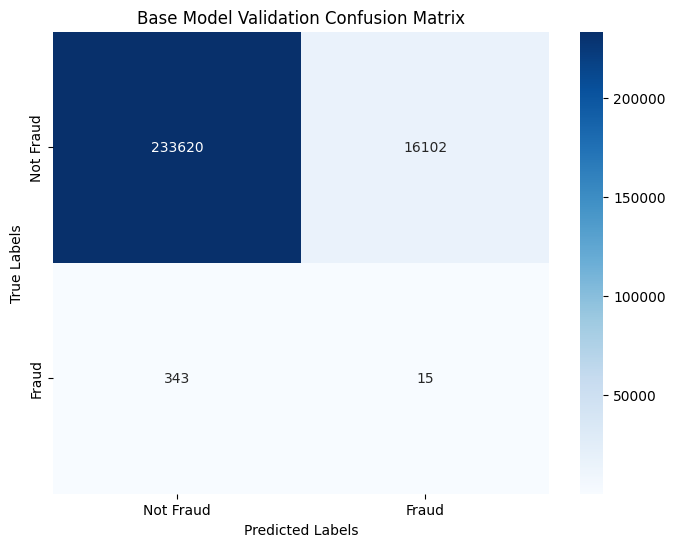

In [25]:
print("Confusion Matrix:\n", confusion_matrix(real, predictions))
plot_confusion_heatmap(
    y_true=real,
    y_pred=predictions,
    class_names=["Not Fraud", "Fraud"],
    title="Base Model Validation Confusion Matrix",
    cmap="Blues"
)